# 日経225 の確率分布

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')
import yfinance as yf

In [ ]:
# 日経225の価格データを取得
start = datetime(2010, 1, 1)
end = datetime.now()
df = yf.download('^N225', start, end)
df['log_adj_close'] = np.log(df['Adj Close'])
df['log_adj_close_diff'] = df['log_adj_close'].diff()
# データの先頭を表示
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume,log_adj_close,log_adj_close_diff
Ticker,^N225,^N225,^N225,^N225,^N225,^N225,,
Date,,,,,,,,
1965-01-05,1257.719971,1257.719971,1257.719971,1257.719971,1257.719971,0,7.137056,NaN
1965-01-06,1263.989990,1263.989990,1263.989990,1263.989990,1263.989990,0,7.142029,0.004973
1965-01-07,1274.270020,1274.270020,1274.270020,1274.270020,1274.270020,0,7.150129,0.008100
1965-01-08,1286.430054,1286.430054,1286.430054,1286.430054,1286.430054,0,7.159626,0.009498
1965-01-12,1288.540039,1288.540039,1288.540039,1288.540039,1288.540039,0,7.161265,0.001639


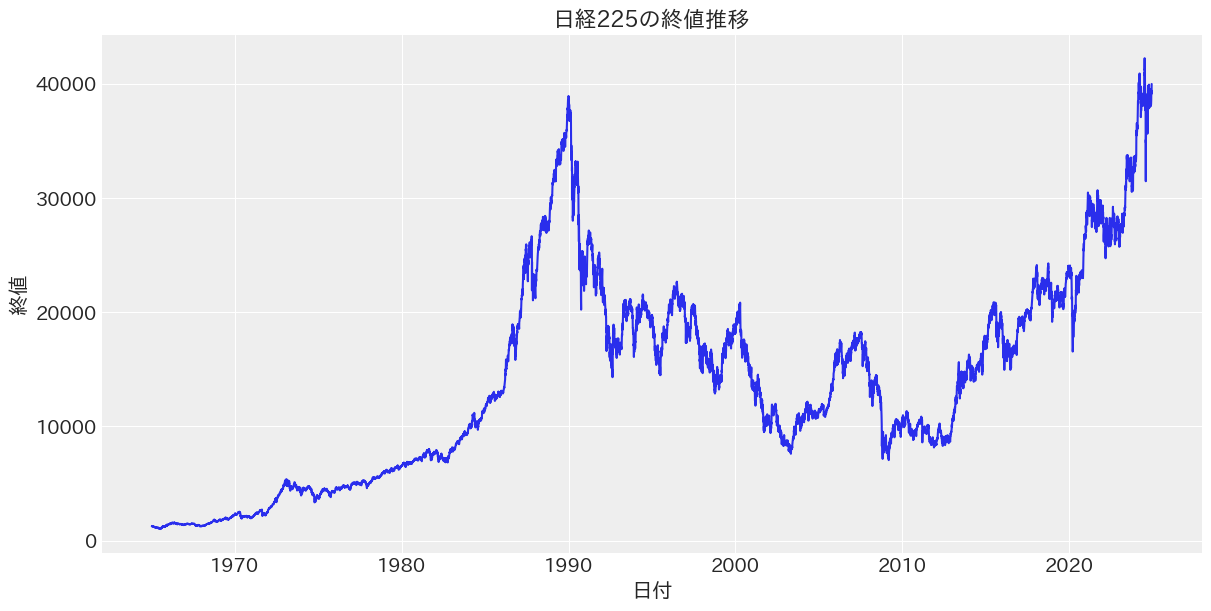

In [17]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=df.index, y=df['Adj Close'].squeeze(), data=df)
plt.title('日経225の終値推移')
plt.xlabel('日付')
plt.ylabel('終値')
plt.show()

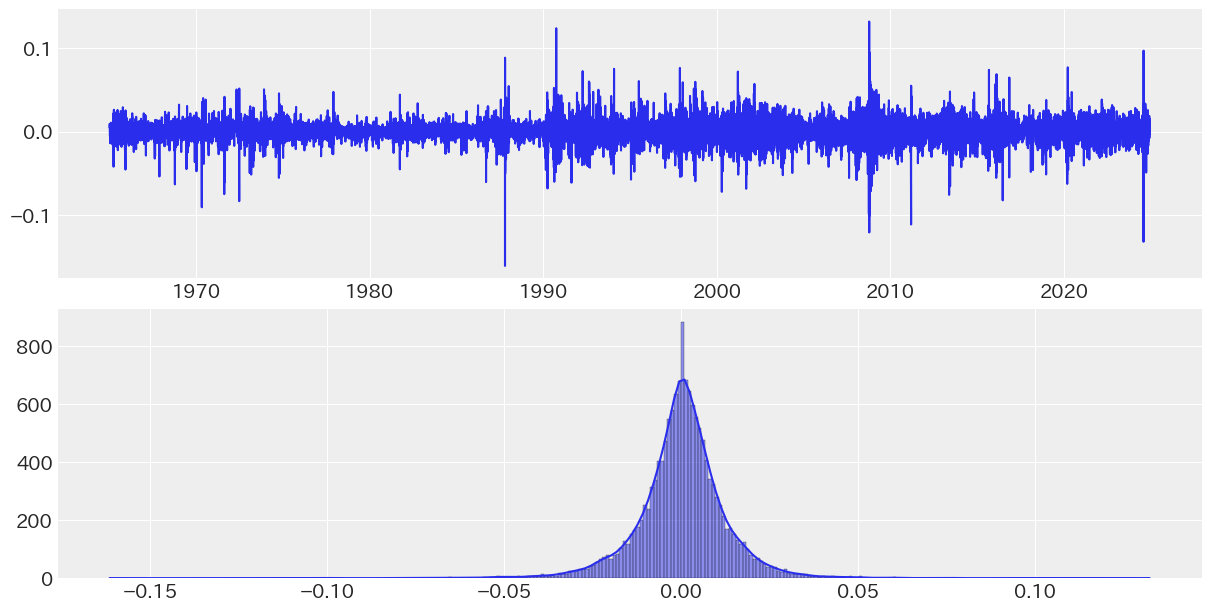

In [3]:
plt.figure(figsize=(12, 6))

plt.subplot(211)
sns.lineplot(x=df.index, y='log_adj_close_diff', data=df)
plt.ylabel('')
plt.xlabel('')

plt.subplot(212)
sns.histplot(df['log_adj_close_diff'], kde=True)
plt.ylabel('')
plt.xlabel('')

plt.show()

## 正規分布

### modeling

$$
\begin{aligned}
y &\sim N(\mu, \sigma^2)\\
\mu &= \mu_{\text{daily}} * 365.25\\
\sigma &= \sigma_{\text{daily}} * \sqrt{365.25}
\end{aligned}
$$

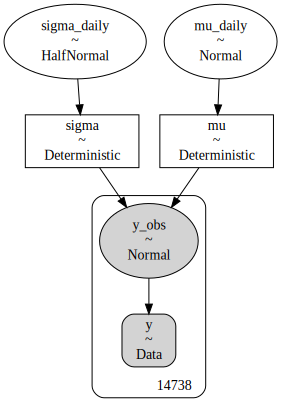

In [3]:
with pm.Model() as model_normal:
    # data
    y = pm.Data('y', df['log_adj_close_diff'].dropna())

    # prior
    mu_daily = pm.Normal('mu_daily', mu=0, sigma=0.01)
    mu = pm.Deterministic('mu', mu_daily * 365.25)
    sigma_daily = pm.HalfNormal('sigma_daily', sigma=0.01)
    sigma = pm.Deterministic('sigma', sigma_daily * np.sqrt(365.25))

    # likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

pm.model_to_graphviz(model_normal)

In [9]:
with model_normal:
    # sampling
    trace_normal = pm.sample(
        draws=2000,
        tune=2000,
        chains=2,
        nuts_sampler='numpyro'
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [10]:
with model_normal:
    pm.sample_posterior_predictive(trace_normal, extend_inferencedata=True)

Sampling: [y_obs]


Output()

In [11]:
az.summary(trace_normal)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_daily,0.000,0.0,0.000,0.000,0.0,0.0,3411.0,2653.0,1.00
sigma_daily,0.001,0.0,0.001,0.001,0.0,0.0,185.0,236.0,1.01
mu,0.000,0.0,0.000,0.000,0.0,0.0,3411.0,2653.0,1.00
sigma,0.013,0.0,0.013,0.013,0.0,0.0,185.0,236.0,1.01


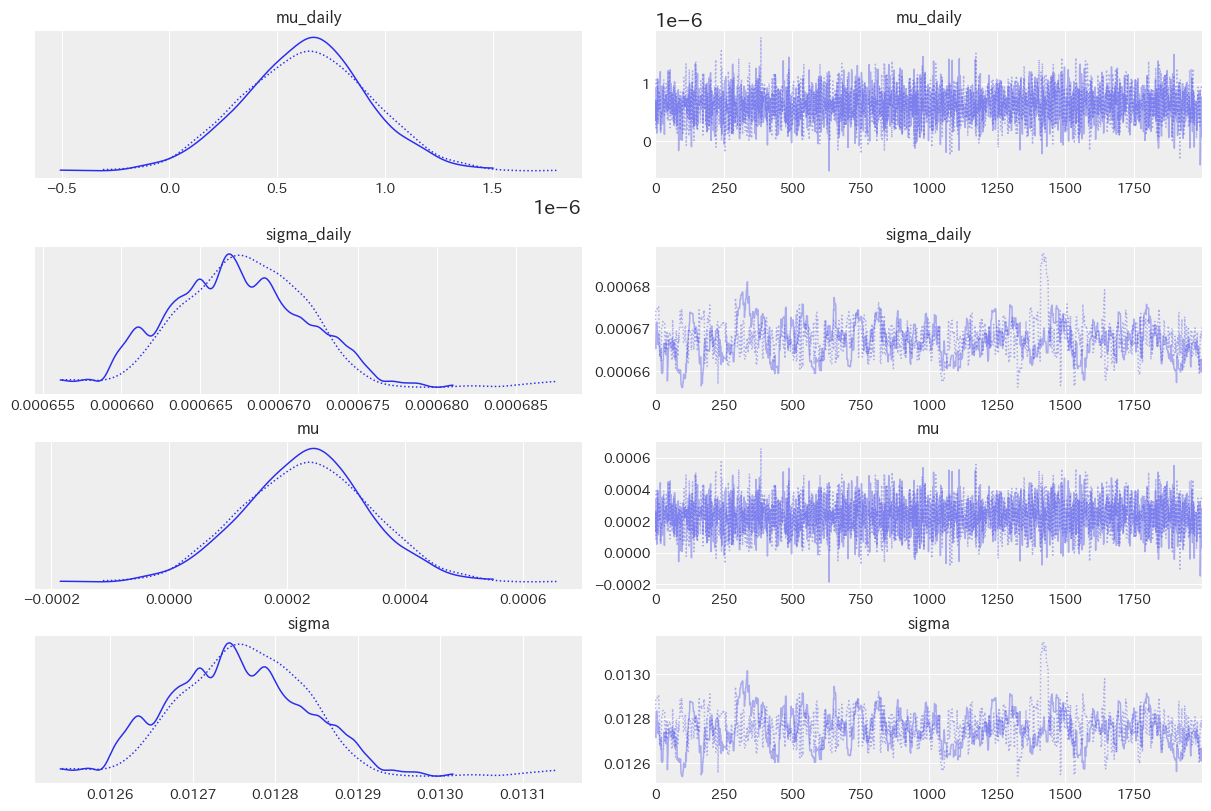

In [12]:
az.plot_trace(trace_normal);

<Figure size 1200x600 with 0 Axes>

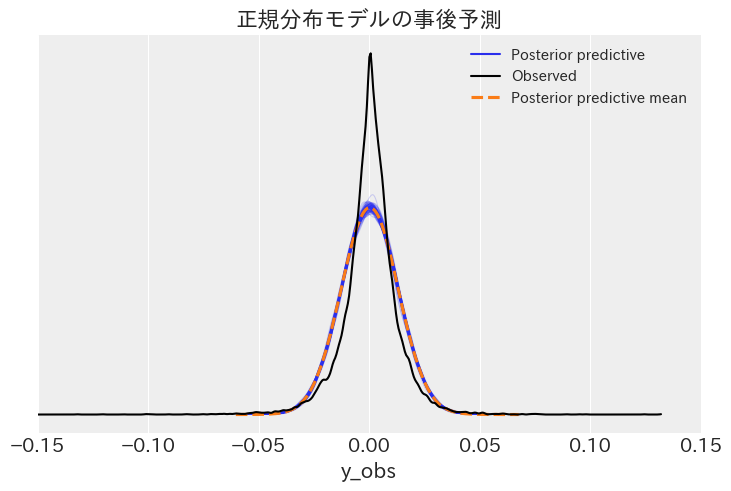

In [13]:
plt.figure(figsize=(12, 6))
az.plot_ppc(trace_normal, num_pp_samples=100)
plt.xlim(-0.15, 0.15)
plt.title('正規分布モデルの事後予測')
plt.show()

## $t$ 分布

### modeling

$$
\begin{aligned}
y &\sim \mathcal{N}(\nu, \mu, \sigma^2)\\
\nu &= \mathcal{Exponential}(lambda=1/30) \\
\mu &= \mu_{\text{daily}} * 365.25\\
\mu_{\text{daily}} &\sim \mathcal{N}(0, 0.01)\\
\sigma &= \sigma_{\text{daily}} * \sqrt{365.25} \\
\sigma_{\text{daily}} &\sim \mathcal{N}^+(0.01)
\end{aligned}
$$

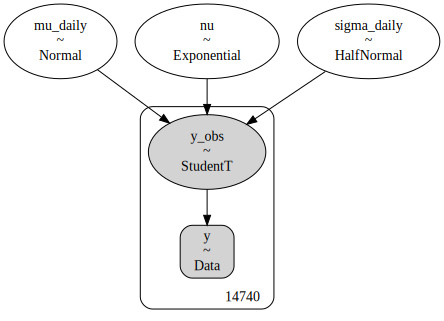

In [3]:
with pm.Model() as model_t:
    # data
    y = pm.Data('y', df['log_adj_close_diff'].dropna())

    # prior
    nu = pm.Exponential('nu', lam=1/10)
    mu_daily = pm.Normal('mu_daily', mu=0, sigma=0.01)
    # mu = pm.Deterministic('mu', mu_daily * 365.25)
    sigma_daily = pm.HalfNormal('sigma_daily', sigma=0.01)
    # sigma = pm.Deterministic('sigma', sigma_daily * np.sqrt(365.25))

    # likelihood
    y_obs = pm.StudentT('y_obs', mu=mu_daily, sigma=sigma_daily, nu=nu, observed=y)

pm.model_to_graphviz(model_t)

In [4]:
with model_t:
    # sampling
    trace_t = pm.sample(
        draws=1000,
        tune=2500,
        chains=2,
        nuts_sampler='numpyro'
    )

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [5]:
with model_t:
    pm.sample_posterior_predictive(trace_t, extend_inferencedata=True)

Sampling: [y_obs]


Output()

### results

In [6]:
az.summary(trace_t)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_daily,0.001,0.000,0.000,0.001,0.000,0.000,2079.0,1302.0,1.00
nu,2.984,0.087,2.824,3.146,0.004,0.003,418.0,568.0,1.01
sigma_daily,0.008,0.000,0.008,0.008,0.000,0.000,443.0,367.0,1.01


In [10]:
annualized_return = trace_t.posterior_predictive['y_obs'].values.flatten().mean() * 365.25
annualized_volatility = trace_t.posterior_predictive['y_obs'].values.flatten().std() * np.sqrt(365.25)
print(f'年率リターン: {annualized_return:.2%}')
print(f'年率ボラティリティ: {annualized_volatility:.2%}')

年率リターン: 19.53%
年率ボラティリティ: 26.63%


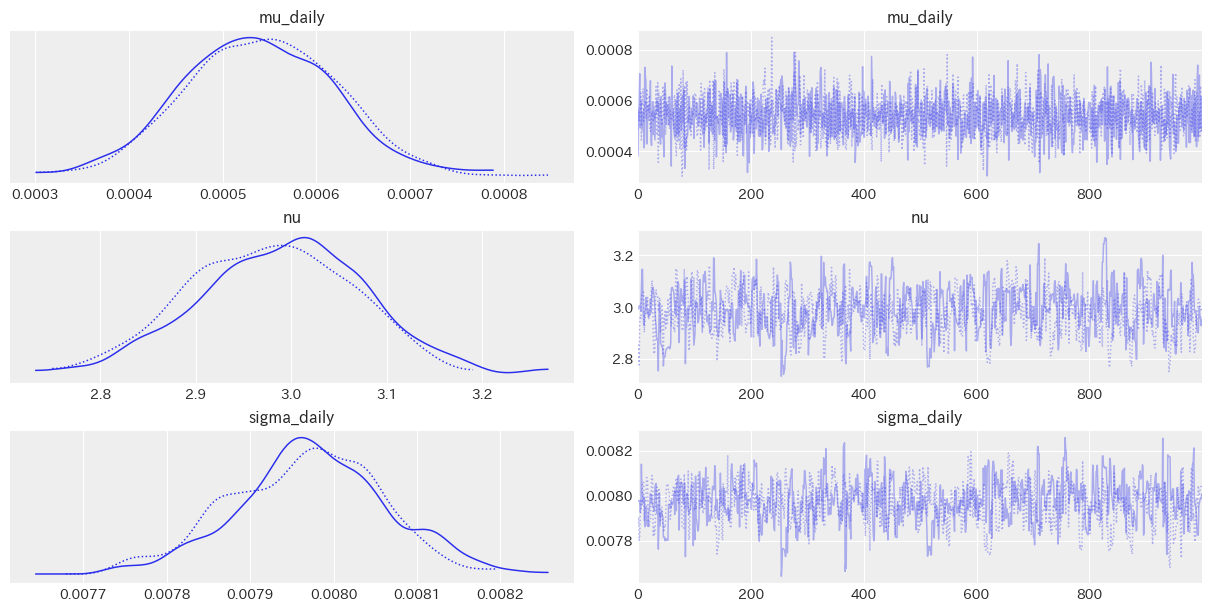

In [7]:
az.plot_trace(trace_t);

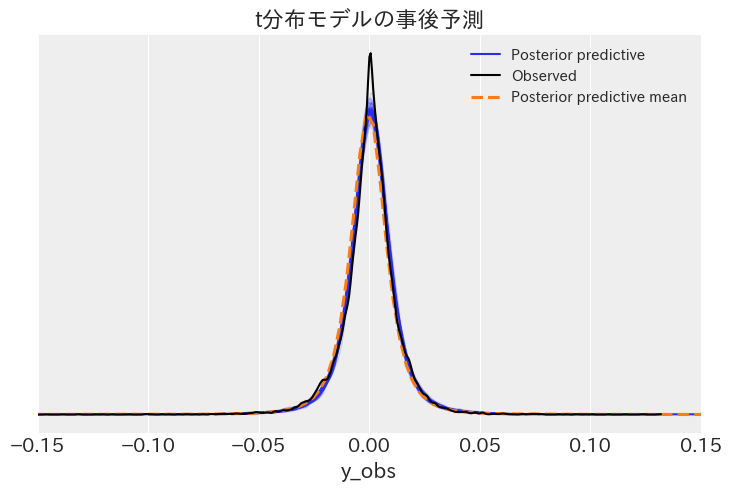

In [11]:
az.plot_ppc(trace_t, num_pp_samples=100)
plt.xlim(-0.15, 0.15)
plt.title('t分布モデルの事後予測')
plt.show()

## サンプリングの保存

In [12]:
az.to_netcdf(trace_t, './../../mcmc_samples/n225_trace_t.nc')

'./../../mcmc_samples/n225_trace_t.nc'